# Extracting circadian parameters from live-cell data

The aim of this tutorial is to use the cosinor_lite Python package to extract circadian parameters from live-cell data. Here we will use bioluminescence data, but in theory any data (e.g. qPCR, cytokine) could be used.

## Core methodology - three types of cosinor models

The core of the methodology is the possibility to choose between three different cosinor models:

- a) Fixed 24-h period

- b) Free period

- c) Free period with damped amplitude

<div style="text-align: center;">
  <img src="../images/live_cell_fitting-01.png" alt="Model selection" style="width:100%;"/>
</div>

Once a model is chosen, it is fitted independently to each sample. The fitted parameters can be exported for downstream statistical analysis.

## Loading data and creating a LiveCellDataset

We first load the data, where we assume it's in a standardised format (see data folder for examples). The data is assumed to have the following format:
- participant_id (row 1)
- replicate (row 2)
- group (row 3)
- time (col 1)
- time series (all the rest of the data from row 4, col 2)

In [1]:
from pathlib import Path

import pandas as pd

from cosinor_lite.livecell_cosinor_analysis import CosinorAnalysis
from cosinor_lite.livecell_dataset import LiveCellDataset

file: Path = Path.cwd().parent / "data" / "bioluminescence_example.csv"

df_data = pd.read_csv(file, header=None)

participant_id = df_data.iloc[0, 1:].astype(str)
replicate = df_data.iloc[1, 1:].astype(int)
group = df_data.iloc[2, 1:].astype(str)
time = df_data.iloc[3:, 0].to_numpy(dtype=float)

time_rows = df_data.iloc[3:, 1:].apply(pd.to_numeric)
time_series = time_rows.to_numpy(dtype=float)

dataset = LiveCellDataset(
    ids=participant_id.tolist(),
    group=group.tolist(),
    replicate=replicate.tolist(),
    time_series=time_series,
    time=time,
    group1_label="Group 1",
    group2_label="Group 2",
)

We can now plot the data and perform detrending using either:
- none
- linear
- poly2 (linear + quadratic terms)
- moving_average (need to provide number of window steps)

As measurements are every 10 mins, we'll use a moving_average window of 240 (24 hour moving average window).
The helper returns a matplotlib figure along with temporary PDF and CSV paths so you can download both the plot and the detrended traces.

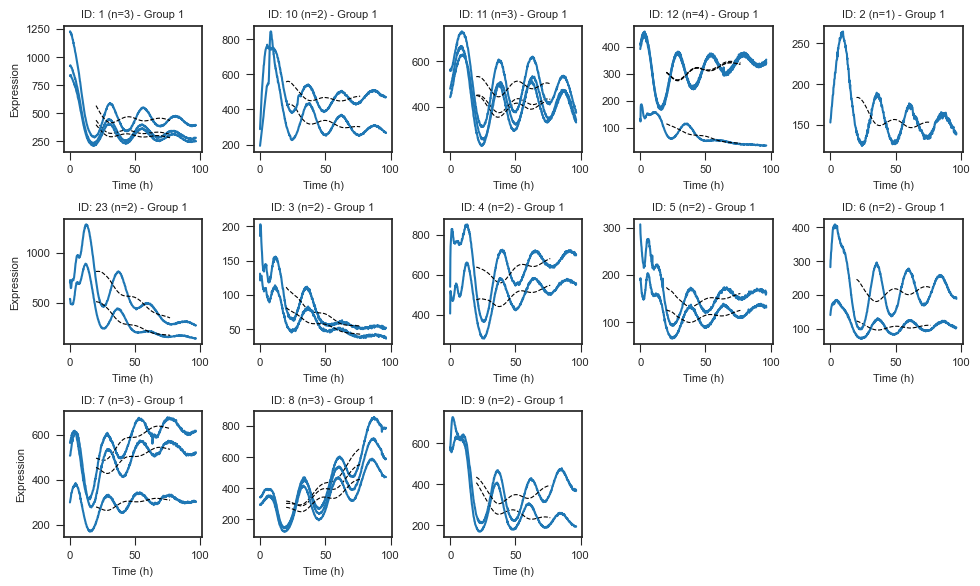

In [2]:
fig, tmp_path, csv_path = dataset.plot_group_data(
    "group1",
    method="moving_average",
    window=240,
    plot_style="line",
)

## Fitting cosinor parameters

We then create a CosinorAnalysis

In [3]:
cosinor_analysis = CosinorAnalysis(
    ids=participant_id.tolist(),
    group=group.tolist(),
    replicate=replicate.tolist(),
    time_series=time_rows.to_numpy(dtype=float),
    time=time,
    group1_label="Group 1",
    group2_label="Group 2",
)

We can then fit our chosen cosinor model from , plot the results and export the parameters as a pandas dataframe df_export, which can then be saved as a .csv file for downstream analysis

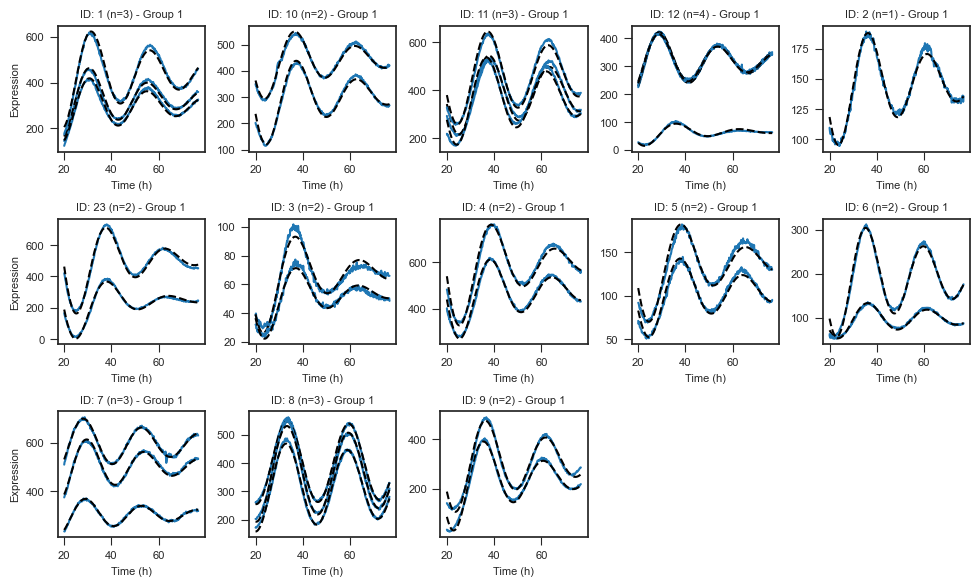

In [4]:
df_export, tmp1_path, fig, tmp2_path = cosinor_analysis.fit_cosinor(
    "group1",
    method="moving_average",
    window=240,
    cosinor_model="cosinor_damped",
    plot_style="line",
)